In [1]:
cd

/home/luxx0489


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import mne
from scipy.io import loadmat, savemat
from scipy.stats import circmean
from sklearn import decomposition
from random import sample

data_path = './jupyter_projects/MultiChannelSSSR/SPIS-Resting-State-Dataset/Pre-SART EEG/'

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
sample_size = [300,600,900,1200,1500]
ind_list = [sample(range(1500),size) for size in sample_size]

len(ind_list[0])

300

In [5]:
ID_list = np.arange(2,18)
mask = np.ones(len(ID_list),dtype=bool)
mask[3] = False

In [6]:
# load data

folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_100_200Hz/"

sample_size = [300,600,900,1200,1500]
plv_out = np.empty((15,len(sample_size),5,224))
ID_list = np.arange(2,18)
mask = np.ones(len(ID_list),dtype=bool)
mask[3] = False

plv_channels = np.empty((15,len(sample_size),64,224))

for iSubject in range(len(ID_list[mask])):
    print(str(iSubject))
    
    # read data
    sub_id = 'Sub' + str(ID_list[mask][iSubject])
    mat_contents = loadmat(folder_path + sub_id+'/'+sub_id+'_TMR-5_MSK_LF_M12_Ref_REcleaned.mat')
    ind_list = [sample(range(1500),size) for size in sample_size]
    
    data = mat_contents['Merged_Data'][:,103:103+446,:]
    nTrial = data.shape[2]

    # FFT
    x=data.transpose(2,0,1)
    xw = np.fft.rfft(np.hamming(x.shape[2])*x, axis=2)
    xw = xw/abs(xw)
    freq = np.fft.rfftfreq(x.shape[2],1/1024)

    for iSize in range(len(sample_size)):
        plv_ave = xw[ind_list[iSize],:,:].mean(0)
        plv_out[iSubject,iSize,0,:] = abs(plv_ave).mean(0)
        plv_out[iSubject,iSize,1,:] = abs(plv_ave[37,:])
        
        plv_channels[iSubject,iSize,:,:] = abs(plv_ave)
        
    # cPCA
        plv_mat=np.empty((64,xw.shape[2]),dtype=np.complex64)
        v_mat = []
        for iFreq in range(xw.shape[2]):
            csd = np.matmul(xw[ind_list[iSize],:,iFreq].T,xw[ind_list[iSize],:,iFreq].conj())
            w,v = np.linalg.eig(csd)
            v_mat.append(v)
            pc = np.matmul(v.conj().T,xw[ind_list[iSize],:,iFreq].T)
            plv = (pc/abs(pc)).mean(1)
            plv_mat[:,iFreq] = plv

        plv_out[iSubject,iSize,2,:] = abs(plv_mat[0,:])
        plv_out[iSubject,iSize,3,:] = abs(plv_mat[1,:])

        # concatenate and tPCA
        mix_long = np.concatenate([x[iTrial,:,:] for iTrial in ind_list[iSize]], axis=1)

        pca = decomposition.PCA(n_components=1)
        pca.fit(mix_long.T)
        pc_t = np.empty((len(ind_list[iSize]),446))
        for iTrial in range(len(ind_list[iSize])):
            pc_t[iTrial,:] = pca.transform(x[ind_list[iSize][iTrial],:,:].T).squeeze()
        xw_pc_t = np.fft.rfft(pc_t, axis=1)
        xw_pc_t = xw_pc_t/abs(xw_pc_t)
        plv_pc_t = xw_pc_t.mean(0)

        plv_out[iSubject,iSize,4,:] = abs(plv_pc_t)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [7]:
data_path = './jupyter_projects/StreamingEEG_exp5/'

file_handle = open(data_path +'electrode_pos.obj','rb')
pos = pickle.load(file_handle)
file_handle.close()

In [8]:
index_1 = np.argmin(abs(freq-98))
index_2 = np.argmin(abs(freq-60))
index_3 = np.argmin(abs(freq-80))

Text(0.5, 1.0, 'PLV of 1500 trials')

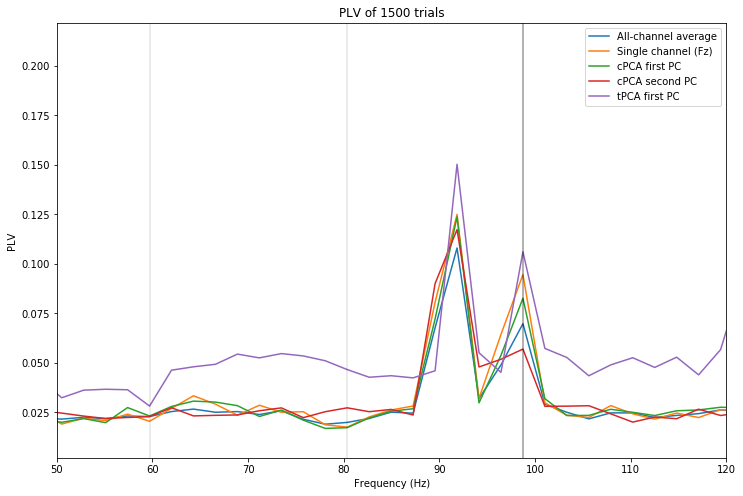

In [9]:
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
plt.figure(figsize=(12,8))

for i in range(5):
    plt.plot(freq,plv_out[:,4,i,:].mean(0),label=lgd_list[i])


plt.legend()
plt.xlim(50,120)
plt.axvline(freq[index_1],color='k',alpha=0.4)
plt.axvline(freq[index_2],color='k',alpha=0.1)
plt.axvline(freq[index_3],color='k',alpha=0.1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PLV')
plt.title('PLV of 1500 trials')

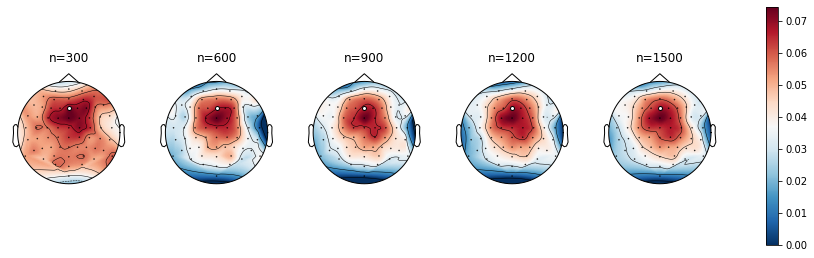

In [12]:
plv_n_channel = np.empty((15,5,64))


for iChannel in range(64):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_channels[iSubject,iSize,iChannel,index_1]
            noise = plv_channels[iSubject,iSize,iChannel,index_2:index_3]
            plv_n_channel[iSubject,iSize,iChannel] = signal-noise.mean()


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iSize in range(5):
    im,_=mne.viz.plot_topomap(plv_n_channel[:,iSize,:].mean(0),pos,axes=axes[iSize],show=False,mask=mask_channel,cmap="RdBu_r")
    axes[iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

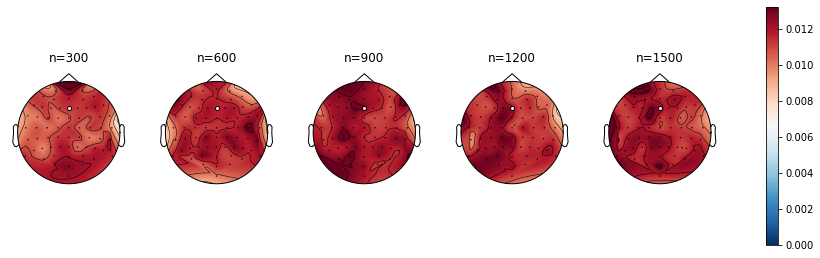

In [13]:
plv_n_channel = np.empty((15,5,64))


for iChannel in range(64):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_channels[iSubject,iSize,iChannel,index_1]
            noise = plv_channels[iSubject,iSize,iChannel,index_2:index_3]
            plv_n_channel[iSubject,iSize,iChannel] = noise.std()


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iSize in range(5):
    im,_=mne.viz.plot_topomap(plv_n_channel[:,iSize,:].mean(0),pos,axes=axes[iSize],show=False,mask=mask_channel,cmap="RdBu_r")
    axes[iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

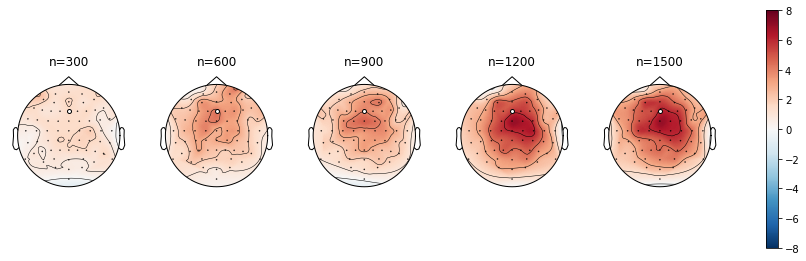

In [119]:
plv_n_channel = np.empty((15,5,64))


for iChannel in range(64):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_channels[iSubject,iSize,iChannel,index_1]
            noise = plv_channels[iSubject,iSize,iChannel,index_2:index_3]
            plv_n_channel[iSubject,iSize,iChannel] = (signal-noise.mean())/noise.std()


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iSize in range(5):
    im,_=mne.viz.plot_topomap(plv_n_channel[:,iSize,:].mean(0),pos,axes=axes[iSize],show=False,mask=mask_channel,vmin=-8,vmax=8,cmap="RdBu_r")
    axes[iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

([<matplotlib.axis.XTick at 0x7f46d4878350>,
 <a list of 5 Text xticklabel objects>)

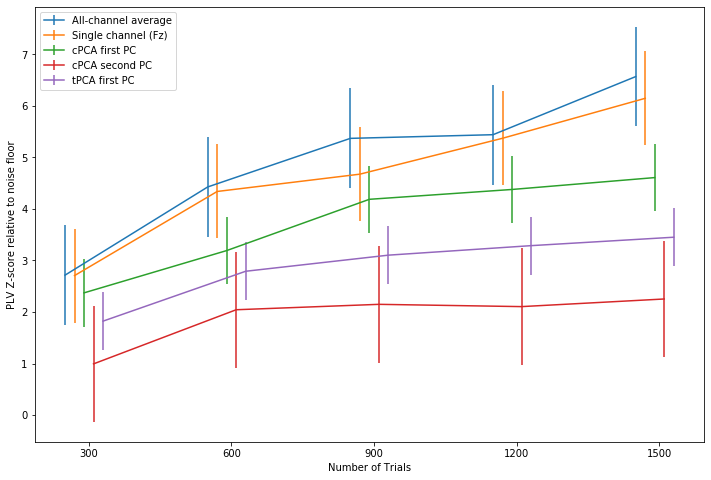

In [10]:
plv_n = np.empty(plv_out.shape[0:3])

for iMethod in range(5):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_out[iSubject,iSize,iMethod,index_1]
            noise = plv_out[iSubject,iSize,iMethod,index_2:index_3]
            plv_n[iSubject,iSize,iMethod] = (signal-noise.mean())/noise.std()

plt.figure(figsize=(12,8))
            
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
for i in range(5):
    plt.errorbar([size+i*20-50 for size in sample_size],plv_n[:,:,i].mean(0),yerr=plv_n[:,:,i].std()/np.sqrt(15)
                 ,label=lgd_list[i])
    
plt.legend(loc='upper left')
plt.xlabel('Number of Trials')
plt.ylabel('PLV Z-score relative to noise floor')
plt.xticks(sample_size)

([<matplotlib.axis.XTick at 0x7f55c4d16890>,
 <a list of 5 Text xticklabel objects>)

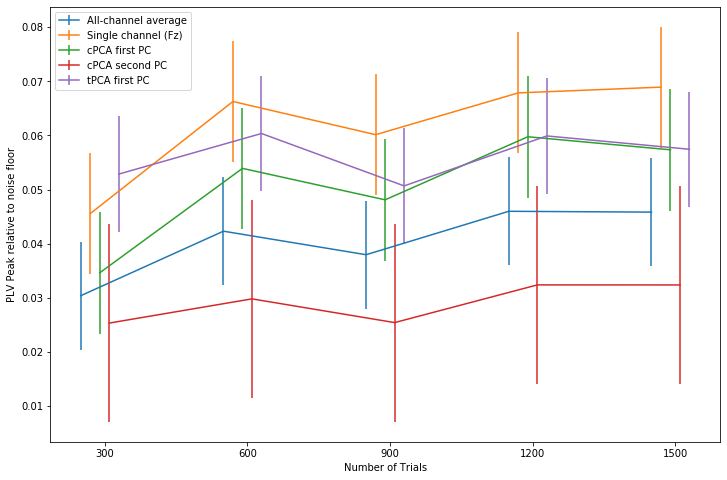

In [120]:
plv_n = np.empty(plv_out.shape[0:3])

for iMethod in range(5):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_out[iSubject,iSize,iMethod,index_1]
            noise = plv_out[iSubject,iSize,iMethod,index_2:index_3]
            plv_n[iSubject,iSize,iMethod] = signal-noise.mean()

plt.figure(figsize=(12,8))
            
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
for i in range(5):
    plt.errorbar([size+i*20-50 for size in sample_size],plv_n[:,:,i].mean(0),yerr=plv_n[:,:,i].std()/np.sqrt(15),label=lgd_list[i])
    
plt.legend(loc='upper left')
plt.xlabel('Number of Trials')
plt.ylabel('PLV Peak relative to noise floor')
plt.xticks(sample_size)

([<matplotlib.axis.XTick at 0x7f55c4c9ee10>,
 <a list of 5 Text xticklabel objects>)

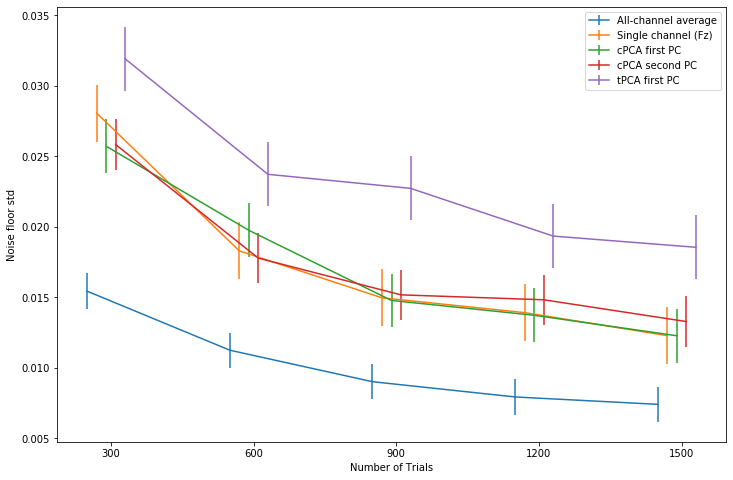

In [121]:
plv_n = np.empty(plv_out.shape[0:3])

for iMethod in range(5):
    for iSize in range(5):
        for iSubject in range(15):
            plv_n[iSubject,iSize,iMethod] = plv_out[iSubject,iSize,iMethod,index_2:index_3].std()

plt.figure(figsize=(12,8))
            
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
for i in range(5):
    plt.errorbar([size+i*20-50 for size in sample_size],plv_n[:,:,i].mean(0),yerr=plv_n[:,:,i].std()/4,label=lgd_list[i])
    
plt.legend(loc='upper right')
plt.xlabel('Number of Trials')
plt.ylabel('Noise floor std')
plt.xticks(sample_size)

In [14]:
# load data

folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_100_200Hz/"

sample_size = [300,600,900,1200,1500]
plv_out = np.empty((15,len(sample_size),5,224))
ID_list = np.arange(2,18)
mask = np.ones(len(ID_list),dtype=bool)
mask[3] = False

plv_channels = np.empty((15,len(sample_size),64,224))

for iSubject in range(len(ID_list[mask])):
    print(str(iSubject))
    
    # read data
    sub_id = 'Sub' + str(ID_list[mask][iSubject])
    mat_contents = loadmat(folder_path + sub_id+'/'+sub_id+'_TMR-5_MSK_HF_M12_Ref_REcleaned.mat')
    ind_list = [sample(range(1500),size) for size in sample_size]
    
    data = mat_contents['Merged_Data'][:,103:103+446,:]
    nTrial = data.shape[2]

    # FFT
    x=data.transpose(2,0,1)
    xw = np.fft.rfft(np.hamming(x.shape[2])*x, axis=2)
    xw = xw/abs(xw)
    freq = np.fft.rfftfreq(x.shape[2],1/1024)

    for iSize in range(len(sample_size)):
        plv_ave = xw[ind_list[iSize],:,:].mean(0)
        plv_out[iSubject,iSize,0,:] = abs(plv_ave).mean(0)
        plv_out[iSubject,iSize,1,:] = abs(plv_ave[37,:])
        
        plv_channels[iSubject,iSize,:,:] = abs(plv_ave)
        
    # cPCA
        plv_mat=np.empty((64,xw.shape[2]),dtype=np.complex64)
        v_mat = []
        for iFreq in range(xw.shape[2]):
            csd = np.matmul(xw[ind_list[iSize],:,iFreq].T,xw[ind_list[iSize],:,iFreq].conj())
            w,v = np.linalg.eig(csd)
            v_mat.append(v)
            pc = np.matmul(v.conj().T,xw[ind_list[iSize],:,iFreq].T)
            plv = (pc/abs(pc)).mean(1)
            plv_mat[:,iFreq] = plv

        plv_out[iSubject,iSize,2,:] = abs(plv_mat[0,:])
        plv_out[iSubject,iSize,3,:] = abs(plv_mat[1,:])

        # concatenate and tPCA
        mix_long = np.concatenate([x[iTrial,:,:] for iTrial in ind_list[iSize]], axis=1)

        pca = decomposition.PCA(n_components=1)
        pca.fit(mix_long.T)
        pc_t = np.empty((len(ind_list[iSize]),446))
        for iTrial in range(len(ind_list[iSize])):
            pc_t[iTrial,:] = pca.transform(x[ind_list[iSize][iTrial],:,:].T).squeeze()
        xw_pc_t = np.fft.rfft(pc_t, axis=1)
        xw_pc_t = xw_pc_t/abs(xw_pc_t)
        plv_pc_t = xw_pc_t.mean(0)

        plv_out[iSubject,iSize,4,:] = abs(plv_pc_t)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [19]:
index_1 = np.argmin(abs(freq-233.13))
index_2 = np.argmin(abs(freq-180))
index_3 = np.argmin(abs(freq-200))

Text(0, 0.5, 'PLV')

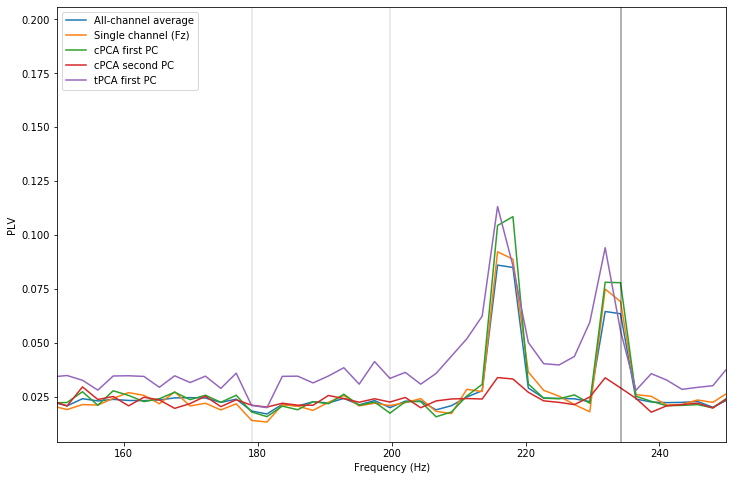

In [125]:
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
plt.figure(figsize=(12,8))

for i in range(5):
    plt.plot(freq,plv_out[:,4,i,:].mean(0),label=lgd_list[i])


plt.legend()
plt.xlim(150,250)
plt.axvline(freq[index_1],color='k',alpha=0.4)
plt.axvline(freq[index_2],color='k',alpha=0.1)
plt.axvline(freq[index_3],color='k',alpha=0.1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PLV')

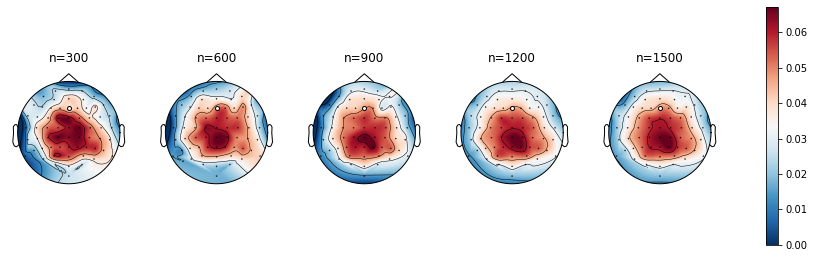

In [20]:
plv_n_channel = np.empty((15,5,64))


for iChannel in range(64):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_channels[iSubject,iSize,iChannel,index_1]
            noise = plv_channels[iSubject,iSize,iChannel,index_2:index_3]
            plv_n_channel[iSubject,iSize,iChannel] = (signal-noise.mean())


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iSize in range(5):
    im,_=mne.viz.plot_topomap(plv_n_channel[:,iSize,:].mean(0),pos,axes=axes[iSize],show=False,mask=mask_channel,cmap="RdBu_r")
    axes[iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

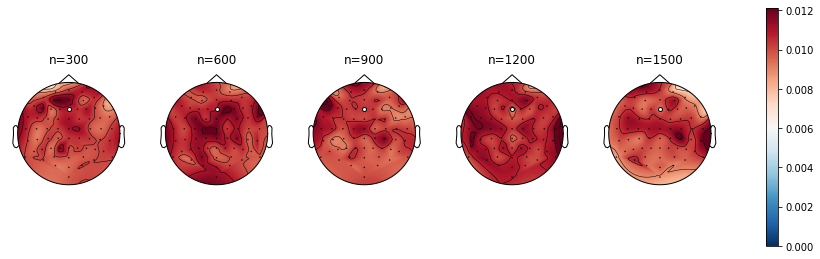

In [21]:
plv_n_channel = np.empty((15,5,64))


for iChannel in range(64):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_channels[iSubject,iSize,iChannel,index_1]
            noise = plv_channels[iSubject,iSize,iChannel,index_2:index_3]
            plv_n_channel[iSubject,iSize,iChannel] = noise.std()


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iSize in range(5):
    im,_=mne.viz.plot_topomap(plv_n_channel[:,iSize,:].mean(0),pos,axes=axes[iSize],show=False,mask=mask_channel,cmap="RdBu_r")
    axes[iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

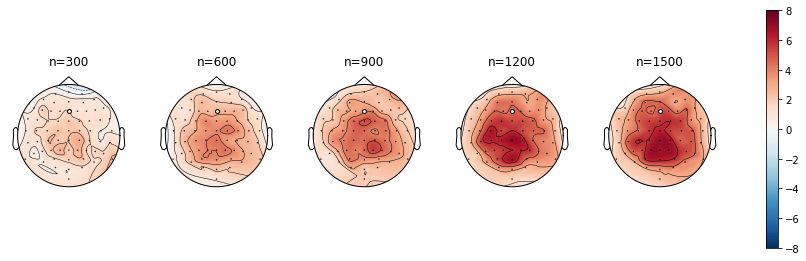

In [128]:
plv_n_channel = np.empty((15,5,64))


for iChannel in range(64):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_channels[iSubject,iSize,iChannel,index_1]
            noise = plv_channels[iSubject,iSize,iChannel,index_2:index_3]
            plv_n_channel[iSubject,iSize,iChannel] = (signal-noise.mean())/noise.std()


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iSize in range(5):
    im,_=mne.viz.plot_topomap(plv_n_channel[:,iSize,:].mean(0),pos,axes=axes[iSize],show=False,mask=mask_channel,vmin=-8,vmax=8,cmap="RdBu_r")
    axes[iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

([<matplotlib.axis.XTick at 0x7f55c4b20510>,
 <a list of 5 Text xticklabel objects>)

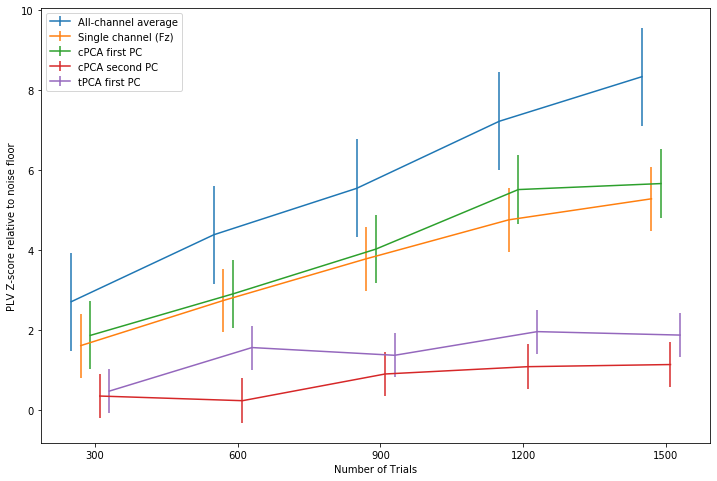

In [127]:
plv_n = np.empty(plv_out.shape[0:3])

for iMethod in range(5):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_out[iSubject,iSize,iMethod,index_1]
            noise = plv_out[iSubject,iSize,iMethod,index_2:index_3]
            plv_n[iSubject,iSize,iMethod] = (signal-noise.mean())/noise.std()

plt.figure(figsize=(12,8))
            
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
for i in range(5):
    plt.errorbar([size+i*20-50 for size in sample_size],plv_n[:,:,i].mean(0),yerr=plv_n[:,:,i].std()/4,label=lgd_list[i])
    
plt.legend(loc='upper left')
plt.xlabel('Number of Trials')
plt.ylabel('PLV Z-score relative to noise floor')
plt.xticks(sample_size)

([<matplotlib.axis.XTick at 0x7f55c47dbe50>,
 <a list of 5 Text xticklabel objects>)

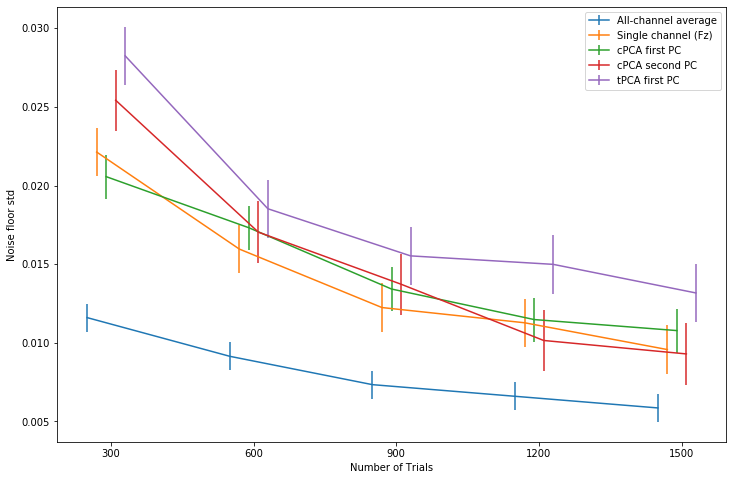

In [130]:
plv_n = np.empty(plv_out.shape[0:3])

for iMethod in range(5):
    for iSize in range(5):
        for iSubject in range(15):
            plv_n[iSubject,iSize,iMethod] = plv_out[iSubject,iSize,iMethod,index_2:index_3].std()

plt.figure(figsize=(12,8))
            
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
for i in range(5):
    plt.errorbar([size+i*20-50 for size in sample_size],plv_n[:,:,i].mean(0),yerr=plv_n[:,:,i].std()/4,label=lgd_list[i])
    
plt.legend(loc='upper right')
plt.xlabel('Number of Trials')
plt.ylabel('Noise floor std')
plt.xticks(sample_size)

([<matplotlib.axis.XTick at 0x7f55c4681fd0>,
 <a list of 5 Text xticklabel objects>)

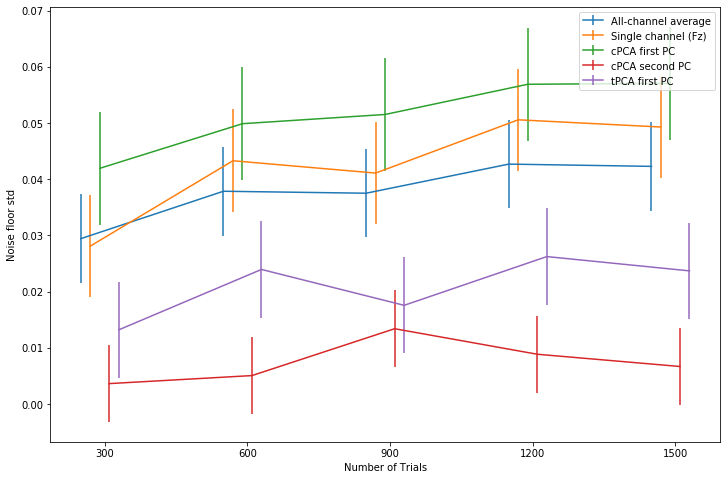

In [132]:
plv_n = np.empty(plv_out.shape[0:3])


for iMethod in range(5):
    for iSize in range(5):
        for iSubject in range(15):
            signal = plv_out[iSubject,iSize,iMethod,index_1]
            noise = plv_out[iSubject,iSize,iMethod,index_2:index_3]
            plv_n[iSubject,iSize,iMethod] = signal-noise.mean()

plt.figure(figsize=(12,8))
            
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','cPCA second PC','tPCA first PC']
for i in range(5):
    plt.errorbar([size+i*20-50 for size in sample_size],plv_n[:,:,i].mean(0),yerr=plv_n[:,:,i].std()/4,label=lgd_list[i])
    
plt.legend(loc='upper right')
plt.xlabel('Number of Trials')
plt.ylabel('Noise floor std')
plt.xticks(sample_size)